In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('creditcard.csv')
df.drop(columns = 'Time', inplace = True)
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [5]:
np.unique(df['Class'], return_counts=True)

(array([0, 1], dtype=int64), array([284315,    492], dtype=int64))

* 데이터 전처리 및 훈련/테스트 데이터셋 분리

In [6]:
# Class가 y , 그 이외는 x

from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values          # X = df.values[:, :-1]
y = df['Class'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=0
)

In [7]:
label, count = np.unique(y_train, return_counts=True)
print(count)

y_train.shape

# 이 때 뒤에서 label이라는 값을 사용하지 않을 것이라면 그냥 언더바(_)로 표시하기도 한다

[199020    344]


(199364,)

In [8]:
# 학습 데이터 레이블 값 비율
label, count = np.unique(y_train, return_counts=True)
print(f'학습 데이터 레이블 값 비율 : {count[1] / y_train.shape[0] * 100:.4f} %')

# 테스트 데이터 레이블 값 비율
label, count = np.unique(y_test, return_counts=True)
print(f'테스트 데이터 레이블 값 비율 : {count[1] / y_test.shape[0] * 100:.4f} %')

학습 데이터 레이블 값 비율 : 0.1725 %
테스트 데이터 레이블 값 비율 : 0.1732 %


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score
def get_clf_eval(y, pred):
    print(confusion_matrix(y, pred))
    print(f'정확도 : {accuracy_score(y, pred):.4f}, 정밀도 : {precision_score(y, pred):.4f}, 재현율 : {recall_score(y, pred):.4f}, F1 : {f1_score(y, pred):.4f}')
    

In [10]:
from sklearn.linear_model import LogisticRegression
lrc = LogisticRegression(max_iter = 1000)
%time lrc.fit(X_train, y_train)
lr_pred = lrc.predict(X_test)

Wall time: 30.9 s


In [11]:
get_clf_eval(y_test, lr_pred)

[[85281    14]
 [   57    91]]
정확도 : 0.9992, 정밀도 : 0.8667, 재현율 : 0.6149, F1 : 0.7194


* LightGBM

In [12]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()
lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [13]:
lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, objective='binary', boost_from_average = False)
%time lgbm.fit(X_train, y_train)
lg_pred = lgbm.predict(X_test)

Wall time: 32.6 s


In [14]:
get_clf_eval(y_test, lg_pred)

[[85290     5]
 [   36   112]]
정확도 : 0.9995, 정밀도 : 0.9573, 재현율 : 0.7568, F1 : 0.8453


In [15]:
import seaborn as sns

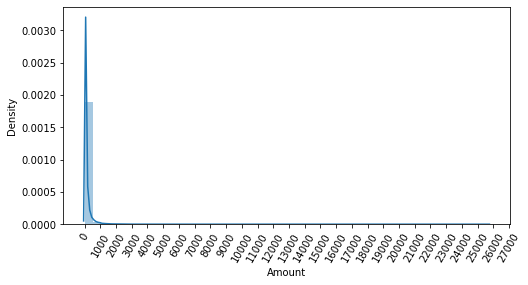

In [20]:
plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation = 60)
sns.distplot(df['Amount'])
plt.show()

* 표준정규분포로 정규화한 뒤 시행

In [22]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(df.iloc[:, :-1])
X_train_std, X_test_std, y_train, y_test = train_test_split(
    X_std, df['Class'].values, stratify=df['Class'].values, test_size=0.3,
    random_state=2021
)

In [23]:
# Logistic 회귀

lrc2 = LogisticRegression()
%time lrc2.fit(X_train_std, y_train)
lr_pred2 = lrc2.predict(X_test_std)
get_clf_eval(y_test, lr_pred2)

Wall time: 1.78 s
[[85278    17]
 [   56    92]]
정확도 : 0.9991, 정밀도 : 0.8440, 재현율 : 0.6216, F1 : 0.7160


정확도 : 0.9992, 정밀도 : 0.8667, 재현율 : 0.6149, F1 : 0.7194

In [24]:
# Light GBM
lgbm2 = LGBMClassifier(n_estimators=1000, num_leaves=64, objective='binary', boost_from_average = False)
lgbm2.fit(X_train_std, y_train)
lg_pred2 = lgbm2.predict(X_test_std)
get_clf_eval(y_test, lg_pred2)

[[85289     6]
 [   35   113]]
정확도 : 0.9995, 정밀도 : 0.9496, 재현율 : 0.7635, F1 : 0.8464


정확도 : 0.9995, 정밀도 : 0.9573, 재현율 : 0.7568, F1 : 0.8453